# CS352 Semester Project

#### Nauman Asif - 2021510 | Sohaib Nasir - 2021609

### Description:
This Jupyter Notebooks file contains the implementation of DCGAN on Fashion MNIST Dataset, trained for 100 Epochs in checkpoints of 10.

## Setting up Colab

In [18]:
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Importing Libraries

In [19]:
import os

import numpy as np
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint

from matplotlib import pyplot as plt

from keras.datasets.fashion_mnist import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout

## Loading Dataset

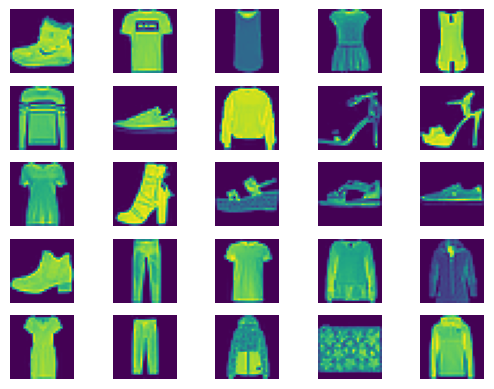

In [20]:
(trainX, trainy), (testX, testy) = load_data()

# plot 25 images
for i in range(25):
	plt.subplot(5, 5, 1 + i)
	plt.axis('off')
	plt.imshow(trainX[i])
plt.show()

In [21]:
trainX[0].shape

(28, 28)

## Image Preprocessing

In [22]:
# image preprocessing

trainX = trainX.reshape(60000, 28, 28, 1)
testX = testX.reshape(10000, 28, 28, 1)

In [23]:
trainX[0].shape

(28, 28, 1)

## Defining the Models

In [24]:
# define the standalone discriminator model
# Given an input image, the Discriminator outputs the likelihood of the image being real.
# Binary classification - true or false (1 or 0). So using sigmoid activation.
def define_discriminator(in_shape=(28,28,1)):
	model = Sequential()

	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same', input_shape=in_shape)) # 14x14x128
	model.add(LeakyReLU(alpha=0.2))

	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same')) # 7x7x128
	model.add(LeakyReLU(alpha=0.2))

	model.add(Flatten()) # shape of 6272
	model.add(Dropout(0.4))
	model.add(Dense(1, activation='sigmoid')) # shape of 1
	# compile model
	opt = Adam(learning_rate=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

test_discr = define_discriminator()
print(test_discr.summary())

# define the standalone generator model
# Given input of latent vector, the Generator produces an image. (Here: 28x28)
# latent_dim, for example, can be 100, 1D array of size 100

def define_generator(latent_dim):    #latent_dim is the dimension of the latent vector (e.g., 100)
	model = Sequential()

	# We will reshape input latent vector into 7x7 image as a starting point.
    # So n_nodes for the Dense layer can be 128x7x7 so when we reshape the output
    # it would be 7x7x128 and that can be slowly upscaled to 28x28 image for output.

	n_nodes = 128 * 7 * 7  # 6272 nodes
	model.add(Dense(n_nodes, input_dim=latent_dim)) # Dense layer so we can work with 1D latent vector
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((7, 7, 128)))  # 7x7x128 dataset from the latent vector.
	# upsample to 14x14
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')) # 14x14x128
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 28x28
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')) # 28x28x128
	model.add(LeakyReLU(alpha=0.2))
	# generate
	model.add(Conv2D(1, (8,8), activation='tanh', padding='same')) # 28x28x1
	return model  # Model not compiled as it is not directly trained like the discriminator.
                  # Generator is trained via GAN combined model.

test_gen = define_generator(100)
print(test_gen.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 14, 14, 128)       1280      
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 14, 14, 128)       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 7, 7, 128)         147584    
                                                                 
 leaky_re_lu_11 (LeakyReLU)  (None, 7, 7, 128)         0         
                                                                 
 flatten_2 (Flatten)         (None, 6272)              0         
                                                                 
 dropout_2 (Dropout)         (None, 6272)              0         
                                                                 
 dense_4 (Dense)             (None, 1)                

In [25]:
# define the combined generator and discriminator model, for updating the generator
# Discriminator is trained separately so here only generator will be trained by keeping
# the discriminator constant.
def define_gan(generator, discriminator):
	discriminator.trainable = False  # Discriminator is trained separately. So set to not trainable.
	# connect generator and discriminator
	model = Sequential()
	model.add(generator)
	model.add(discriminator)
	# compile model
	opt = Adam(learning_rate=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

test_gan = define_gan(test_gen, test_discr)
print(test_gan.summary())

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_7 (Sequential)   (None, 28, 28, 1)         1166209   
                                                                 
 sequential_6 (Sequential)   (None, 1)                 155137    
                                                                 
Total params: 1321346 (5.04 MB)
Trainable params: 1166209 (4.45 MB)
Non-trainable params: 155137 (606.00 KB)
_________________________________________________________________
None


## Functions:

#### Helper Functions:

In [26]:
# load fashion-mnist training images
def load_real_samples():
	(trainX, _), (_, _) = load_data()
	# Add an extra dimension which will be used by the filters
	trainX = trainX.reshape(60000, 28, 28, 1)
	# Convert to float and scale.
	X = trainX.astype('float32')
	# scale from [0,255] to [-1,1]
	X = (X - 127.5) / 127.5  # Generator uses tanh activation so rescale
                             # original images to -1 to 1 to match the output of generator.
	return X

# pick a batch of random real samples to train the GAN
# In fact, we will train the GAN on a half batch of real images and another
# half batch of fake images.
# For each real image we assign a label 1 and for fake we assign label 0.
def generate_real_samples(dataset, n_samples):
	# choose random images
	ix = randint(0, dataset.shape[0], n_samples)
	# select the random images and assign it to X
	X = dataset[ix]
	# generate class labels and assign to y
	y = ones((n_samples, 1)) # Label=1 indicating they are real
	return X, y

# generate n_samples number of latent vectors as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

# use the generator to generate n fake examples, with class labels
# Supply the generator, latent_dim and number of samples as input.
# Use the above latent point generator to generate latent points.
def generate_fake_samples(generator, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict using generator to generate fake samples.
	X = generator.predict(x_input)
	# Class labels will be 0 as these samples are fake.
	y = zeros((n_samples, 1))  # Label=0 indicating they are fake
	return X, y

In [27]:
# defining empty lists to store the loss function values of the Discriminator and Generator

d_loss_real_list = []
d_loss_fake_list = []
g_loss_list = []

#### Training Function:

In [28]:
# train the generator and discriminator
# We loop through a number of epochs to train our Discriminator by first selecting
# a random batch of images from our true/real dataset.
# Then, generating a set of images using the generator.
# Feed both set of images into the Discriminator.
# Finally, set the loss parameters for both the real and fake images, as well as the combined loss.

def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=128):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)  # the discriminator model is updated for a half batch of real samples
                            	   # and a half batch of fake samples, combined a single batch.

	# manually enumerate epochs and bacthes.
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):

            # Train the discriminator on real and fake images, separately (half batch each)
        	# Research showed that separate training is more effective.
			# get randomly selected 'real' samples
			X_real, y_real = generate_real_samples(dataset, half_batch)

			# update discriminator model weights
            # train_on_batch allows you to update weights based on a collection
            # of samples you provide
            # Let us just capture loss and ignore accuracy value (2nd output below)
			d_loss_real, _ = d_model.train_on_batch(X_real, y_real)

            # generate 'fake' examples
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# update discriminator model weights
			d_loss_fake, _ = d_model.train_on_batch(X_fake, y_fake)

			# prepare points in latent space as input for the generator
			X_gan = generate_latent_points(latent_dim, n_batch)

            # The generator wants the discriminator to label the generated samples
        	# as valid (ones)
        	# This is where the generator is trying to trick discriminator into believing
        	# the generated image is true (hence value of 1 for y)
			y_gan = ones((n_batch, 1))

            # Generator is part of combined model where it got directly linked with the discriminator
        	# Train the generator with latent_dim as x and 1 as y.
        	# Again, 1 as the output as it is adversarial and if generator did a great
        	# job of folling the discriminator then the output would be 1 (true)
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch(X_gan, y_gan)

            # Print losses on this batch
			print('Epoch>%d, Batch %d/%d, d_real=%.3f, d_fake=%.3f, g=%.3f' %
				(i+1, j+1, bat_per_epo, d_loss_real, d_loss_fake, g_loss))

		d_loss_real_list.append(d_loss_real)
		d_loss_fake_list.append(d_loss_fake)
		g_loss_list.append(g_loss)

	# save the generator model
	g_model.save('/content/drive/MyDrive/Colab Notebooks/DCGAN_fashion-mnist_generator.keras')

	# plot the losses
	plt.plot(d_loss_real_list, label='Discr. Real')
	plt.plot(d_loss_fake_list, label='Discr. Fake')
	plt.plot(g_loss_list, label='Generator')
	plt.title('Model Loss')
	plt.xlabel('Epochs')
	plt.ylabel('Loss')
	plt.legend()
	plt.show()

## Training the GAN

In [29]:
# size of the latent space
latent_dim = 100

# create the discriminator
discriminator = define_discriminator()

# create the generator

# Check if the file exists
if os.path.exists('/content/drive/MyDrive/Colab Notebooks/DCGAN_fashion-mnist_generator.keras'):
    generator = load_model('/content/drive/MyDrive/Colab Notebooks/DCGAN_fashion-mnist_generator.keras')
else:
	generator = define_generator(latent_dim)

# create the gan
gan_model = define_gan(generator, discriminator)

# load image data
dataset = load_real_samples()

Streaming output truncated to the last 5000 lines.
2/2 [==============================] - 0s 5ms/step
Epoch>5, Batch 309/468, d_real=0.654, d_fake=0.697, g=0.761
2/2 [==============================] - 0s 9ms/step
Epoch>5, Batch 310/468, d_real=0.656, d_fake=0.667, g=0.735
2/2 [==============================] - 0s 6ms/step
Epoch>5, Batch 311/468, d_real=0.653, d_fake=0.674, g=0.722
2/2 [==============================] - 0s 7ms/step
Epoch>5, Batch 312/468, d_real=0.647, d_fake=0.712, g=0.712
2/2 [==============================] - 0s 6ms/step
Epoch>5, Batch 313/468, d_real=0.623, d_fake=0.729, g=0.727
2/2 [==============================] - 0s 5ms/step
Epoch>5, Batch 314/468, d_real=0.612, d_fake=0.714, g=0.706
2/2 [==============================] - 0s 5ms/step
Epoch>5, Batch 315/468, d_real=0.616, d_fake=0.746, g=0.707
2/2 [==============================] - 0s 5ms/step
Epoch>5, Batch 316/468, d_real=0.665, d_fake=0.726, g=0.728
2/2 [==============================] - 0s 5ms/step
Epoch>5, B

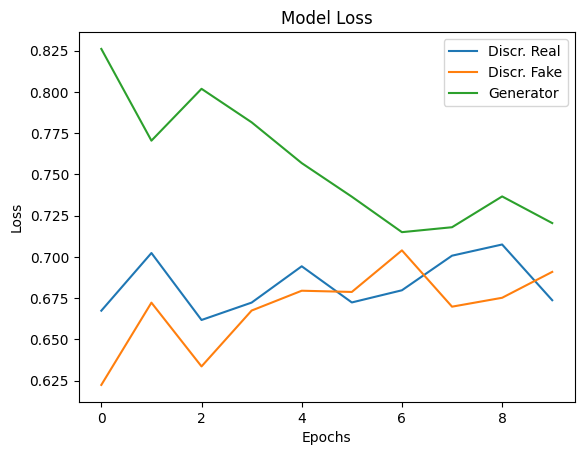

In [30]:
# train model
#1
train(generator, discriminator, gan_model, dataset, latent_dim, n_epochs=10)

Streaming output truncated to the last 5000 lines.
2/2 [==============================] - 0s 5ms/step
Epoch>5, Batch 309/468, d_real=0.699, d_fake=0.677, g=0.718
2/2 [==============================] - 0s 4ms/step
Epoch>5, Batch 310/468, d_real=0.699, d_fake=0.694, g=0.711
2/2 [==============================] - 0s 5ms/step
Epoch>5, Batch 311/468, d_real=0.706, d_fake=0.695, g=0.721
2/2 [==============================] - 0s 5ms/step
Epoch>5, Batch 312/468, d_real=0.695, d_fake=0.698, g=0.709
2/2 [==============================] - 0s 5ms/step
Epoch>5, Batch 313/468, d_real=0.693, d_fake=0.696, g=0.715
2/2 [==============================] - 0s 4ms/step
Epoch>5, Batch 314/468, d_real=0.687, d_fake=0.694, g=0.719
2/2 [==============================] - 0s 5ms/step
Epoch>5, Batch 315/468, d_real=0.699, d_fake=0.688, g=0.724
2/2 [==============================] - 0s 5ms/step
Epoch>5, Batch 316/468, d_real=0.701, d_fake=0.678, g=0.725
2/2 [==============================] - 0s 5ms/step
Epoch>5, B

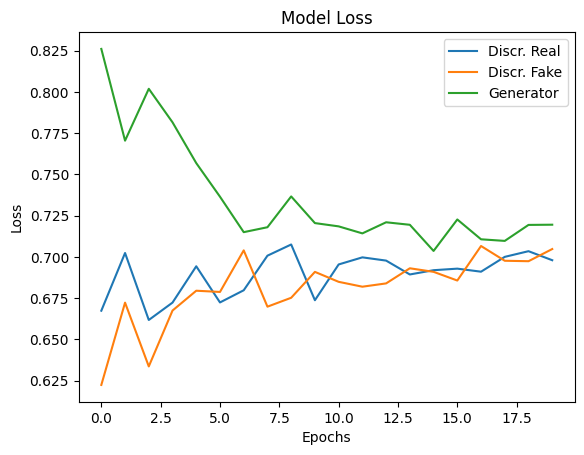

In [31]:
#2
train(generator, discriminator, gan_model, dataset, latent_dim, n_epochs=10)

Streaming output truncated to the last 5000 lines.
2/2 [==============================] - 0s 5ms/step
Epoch>5, Batch 309/468, d_real=0.709, d_fake=0.678, g=0.724
2/2 [==============================] - 0s 5ms/step
Epoch>5, Batch 310/468, d_real=0.693, d_fake=0.699, g=0.715
2/2 [==============================] - 0s 6ms/step
Epoch>5, Batch 311/468, d_real=0.693, d_fake=0.706, g=0.707
2/2 [==============================] - 0s 7ms/step
Epoch>5, Batch 312/468, d_real=0.700, d_fake=0.705, g=0.709
2/2 [==============================] - 0s 5ms/step
Epoch>5, Batch 313/468, d_real=0.688, d_fake=0.696, g=0.707
2/2 [==============================] - 0s 5ms/step
Epoch>5, Batch 314/468, d_real=0.701, d_fake=0.680, g=0.713
2/2 [==============================] - 0s 4ms/step
Epoch>5, Batch 315/468, d_real=0.700, d_fake=0.681, g=0.713
2/2 [==============================] - 0s 6ms/step
Epoch>5, Batch 316/468, d_real=0.706, d_fake=0.699, g=0.715
2/2 [==============================] - 0s 6ms/step
Epoch>5, B

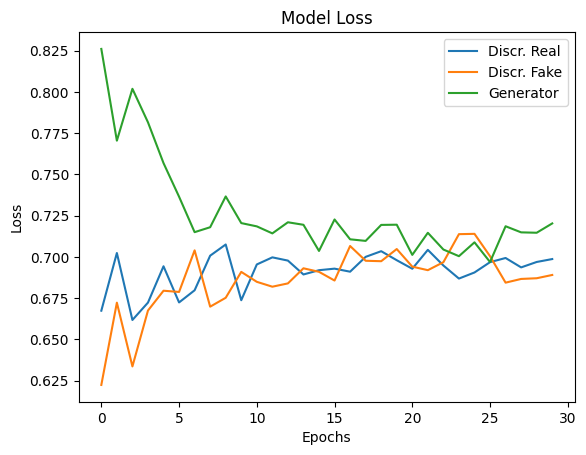

In [32]:
#3
train(generator, discriminator, gan_model, dataset, latent_dim, n_epochs=10)

Streaming output truncated to the last 5000 lines.
2/2 [==============================] - 0s 4ms/step
Epoch>5, Batch 309/468, d_real=0.688, d_fake=0.691, g=0.699
2/2 [==============================] - 0s 8ms/step
Epoch>5, Batch 310/468, d_real=0.702, d_fake=0.697, g=0.702
2/2 [==============================] - 0s 4ms/step
Epoch>5, Batch 311/468, d_real=0.690, d_fake=0.690, g=0.697
2/2 [==============================] - 0s 5ms/step
Epoch>5, Batch 312/468, d_real=0.701, d_fake=0.689, g=0.700
2/2 [==============================] - 0s 5ms/step
Epoch>5, Batch 313/468, d_real=0.687, d_fake=0.702, g=0.692
2/2 [==============================] - 0s 5ms/step
Epoch>5, Batch 314/468, d_real=0.674, d_fake=0.713, g=0.691
2/2 [==============================] - 0s 6ms/step
Epoch>5, Batch 315/468, d_real=0.685, d_fake=0.705, g=0.708
2/2 [==============================] - 0s 5ms/step
Epoch>5, Batch 316/468, d_real=0.684, d_fake=0.704, g=0.703
2/2 [==============================] - 0s 4ms/step
Epoch>5, B

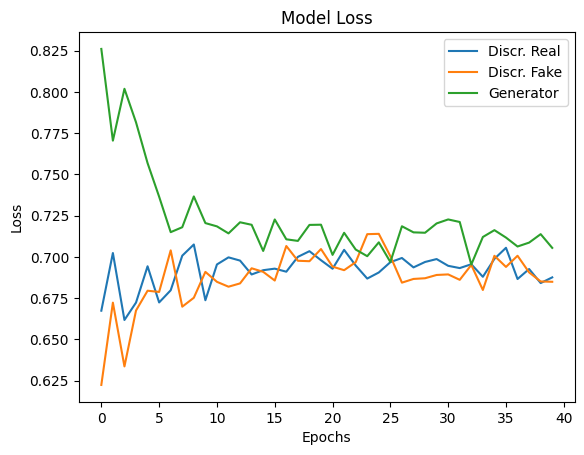

In [33]:
#4
train(generator, discriminator, gan_model, dataset, latent_dim, n_epochs=10)

Streaming output truncated to the last 5000 lines.
2/2 [==============================] - 0s 4ms/step
Epoch>5, Batch 309/468, d_real=0.701, d_fake=0.685, g=0.710
2/2 [==============================] - 0s 5ms/step
Epoch>5, Batch 310/468, d_real=0.689, d_fake=0.678, g=0.716
2/2 [==============================] - 0s 6ms/step
Epoch>5, Batch 311/468, d_real=0.700, d_fake=0.704, g=0.708
2/2 [==============================] - 0s 5ms/step
Epoch>5, Batch 312/468, d_real=0.699, d_fake=0.705, g=0.709
2/2 [==============================] - 0s 5ms/step
Epoch>5, Batch 313/468, d_real=0.692, d_fake=0.695, g=0.705
2/2 [==============================] - 0s 5ms/step
Epoch>5, Batch 314/468, d_real=0.694, d_fake=0.693, g=0.702
2/2 [==============================] - 0s 5ms/step
Epoch>5, Batch 315/468, d_real=0.706, d_fake=0.687, g=0.705
2/2 [==============================] - 0s 5ms/step
Epoch>5, Batch 316/468, d_real=0.696, d_fake=0.691, g=0.697
2/2 [==============================] - 0s 5ms/step
Epoch>5, B

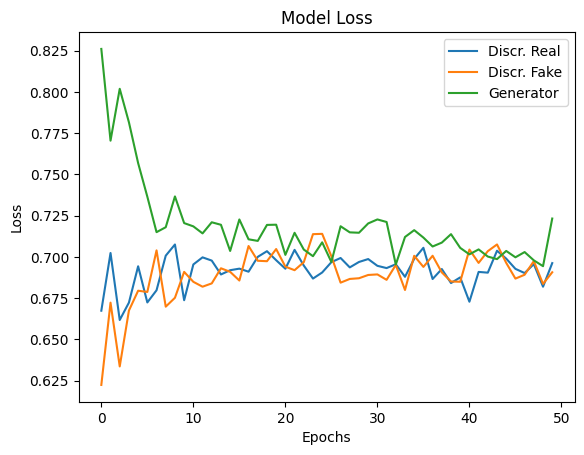

In [34]:
#5
train(generator, discriminator, gan_model, dataset, latent_dim, n_epochs=10)

Streaming output truncated to the last 5000 lines.
2/2 [==============================] - 0s 5ms/step
Epoch>5, Batch 309/468, d_real=0.698, d_fake=0.684, g=0.711
2/2 [==============================] - 0s 6ms/step
Epoch>5, Batch 310/468, d_real=0.704, d_fake=0.699, g=0.701
2/2 [==============================] - 0s 4ms/step
Epoch>5, Batch 311/468, d_real=0.698, d_fake=0.690, g=0.707
2/2 [==============================] - 0s 7ms/step
Epoch>5, Batch 312/468, d_real=0.677, d_fake=0.686, g=0.710
2/2 [==============================] - 0s 4ms/step
Epoch>5, Batch 313/468, d_real=0.695, d_fake=0.697, g=0.706
2/2 [==============================] - 0s 4ms/step
Epoch>5, Batch 314/468, d_real=0.698, d_fake=0.695, g=0.701
2/2 [==============================] - 0s 5ms/step
Epoch>5, Batch 315/468, d_real=0.695, d_fake=0.705, g=0.707
2/2 [==============================] - 0s 5ms/step
Epoch>5, Batch 316/468, d_real=0.695, d_fake=0.691, g=0.697
2/2 [==============================] - 0s 5ms/step
Epoch>5, B

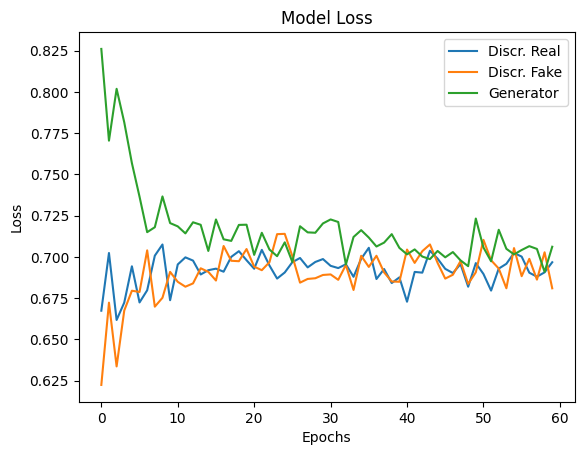

In [35]:
#6
train(generator, discriminator, gan_model, dataset, latent_dim, n_epochs=10)

Streaming output truncated to the last 5000 lines.
2/2 [==============================] - 0s 5ms/step
Epoch>5, Batch 309/468, d_real=0.700, d_fake=0.699, g=0.699
2/2 [==============================] - 0s 6ms/step
Epoch>5, Batch 310/468, d_real=0.695, d_fake=0.694, g=0.703
2/2 [==============================] - 0s 5ms/step
Epoch>5, Batch 311/468, d_real=0.689, d_fake=0.699, g=0.696
2/2 [==============================] - 0s 7ms/step
Epoch>5, Batch 312/468, d_real=0.696, d_fake=0.702, g=0.698
2/2 [==============================] - 0s 5ms/step
Epoch>5, Batch 313/468, d_real=0.694, d_fake=0.695, g=0.697
2/2 [==============================] - 0s 5ms/step
Epoch>5, Batch 314/468, d_real=0.693, d_fake=0.698, g=0.701
2/2 [==============================] - 0s 5ms/step
Epoch>5, Batch 315/468, d_real=0.698, d_fake=0.700, g=0.703
2/2 [==============================] - 0s 6ms/step
Epoch>5, Batch 316/468, d_real=0.688, d_fake=0.691, g=0.695
2/2 [==============================] - 0s 5ms/step
Epoch>5, B

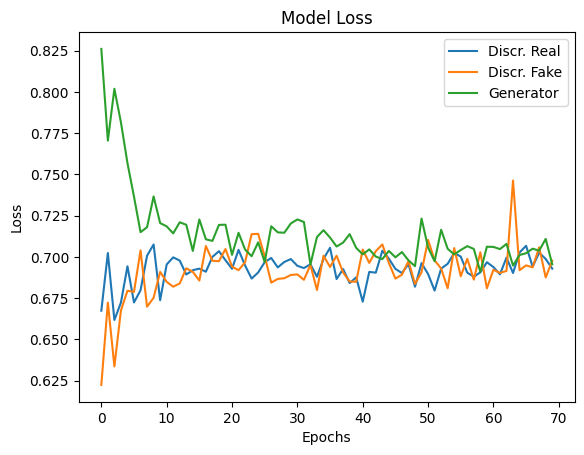

In [36]:
#7
train(generator, discriminator, gan_model, dataset, latent_dim, n_epochs=10)

Streaming output truncated to the last 5000 lines.
2/2 [==============================] - 0s 5ms/step
Epoch>5, Batch 309/468, d_real=0.685, d_fake=0.692, g=0.705
2/2 [==============================] - 0s 5ms/step
Epoch>5, Batch 310/468, d_real=0.696, d_fake=0.692, g=0.708
2/2 [==============================] - 0s 5ms/step
Epoch>5, Batch 311/468, d_real=0.690, d_fake=0.689, g=0.701
2/2 [==============================] - 0s 5ms/step
Epoch>5, Batch 312/468, d_real=0.694, d_fake=0.688, g=0.704
2/2 [==============================] - 0s 5ms/step
Epoch>5, Batch 313/468, d_real=0.696, d_fake=0.687, g=0.697
2/2 [==============================] - 0s 4ms/step
Epoch>5, Batch 314/468, d_real=0.693, d_fake=0.692, g=0.712
2/2 [==============================] - 0s 5ms/step
Epoch>5, Batch 315/468, d_real=0.691, d_fake=0.690, g=0.707
2/2 [==============================] - 0s 4ms/step
Epoch>5, Batch 316/468, d_real=0.681, d_fake=0.687, g=0.703
2/2 [==============================] - 0s 5ms/step
Epoch>5, B

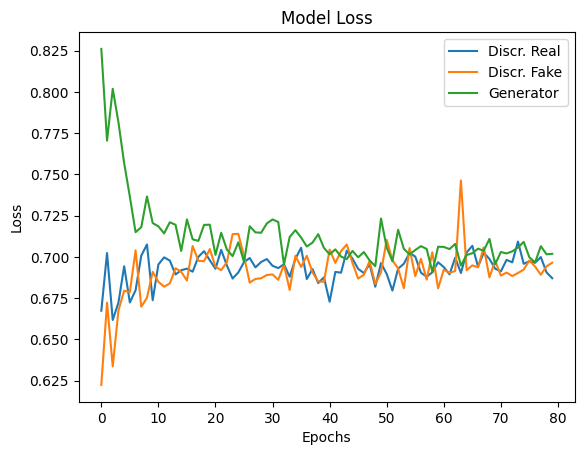

In [37]:
#8
train(generator, discriminator, gan_model, dataset, latent_dim, n_epochs=10)

Streaming output truncated to the last 5000 lines.
2/2 [==============================] - 0s 4ms/step
Epoch>5, Batch 309/468, d_real=0.697, d_fake=0.691, g=0.720
2/2 [==============================] - 0s 4ms/step
Epoch>5, Batch 310/468, d_real=0.690, d_fake=0.677, g=0.711
2/2 [==============================] - 0s 4ms/step
Epoch>5, Batch 311/468, d_real=0.684, d_fake=0.689, g=0.702
2/2 [==============================] - 0s 4ms/step
Epoch>5, Batch 312/468, d_real=0.696, d_fake=0.698, g=0.693
2/2 [==============================] - 0s 6ms/step
Epoch>5, Batch 313/468, d_real=0.703, d_fake=0.720, g=0.703
2/2 [==============================] - 0s 6ms/step
Epoch>5, Batch 314/468, d_real=0.689, d_fake=0.698, g=0.697
2/2 [==============================] - 0s 7ms/step
Epoch>5, Batch 315/468, d_real=0.699, d_fake=0.697, g=0.709
2/2 [==============================] - 0s 12ms/step
Epoch>5, Batch 316/468, d_real=0.687, d_fake=0.686, g=0.709
2/2 [==============================] - 0s 10ms/step
Epoch>5,

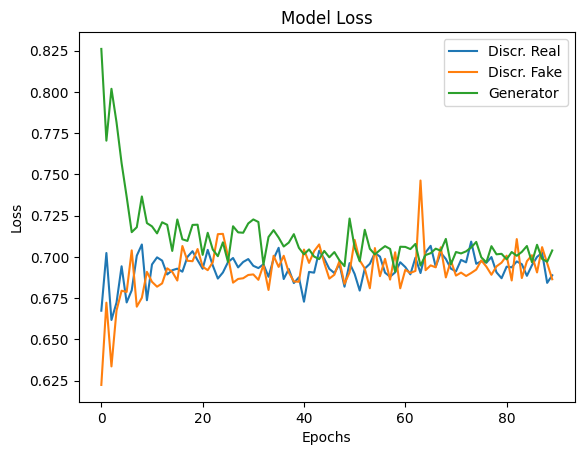

In [38]:
#9
train(generator, discriminator, gan_model, dataset, latent_dim, n_epochs=10)

Streaming output truncated to the last 5000 lines.
2/2 [==============================] - 0s 5ms/step
Epoch>5, Batch 309/468, d_real=0.683, d_fake=0.683, g=0.698
2/2 [==============================] - 0s 6ms/step
Epoch>5, Batch 310/468, d_real=0.698, d_fake=0.693, g=0.699
2/2 [==============================] - 0s 5ms/step
Epoch>5, Batch 311/468, d_real=0.698, d_fake=0.706, g=0.695
2/2 [==============================] - 0s 7ms/step
Epoch>5, Batch 312/468, d_real=0.698, d_fake=0.698, g=0.700
2/2 [==============================] - 0s 5ms/step
Epoch>5, Batch 313/468, d_real=0.689, d_fake=0.701, g=0.699
2/2 [==============================] - 0s 5ms/step
Epoch>5, Batch 314/468, d_real=0.694, d_fake=0.698, g=0.702
2/2 [==============================] - 0s 5ms/step
Epoch>5, Batch 315/468, d_real=0.688, d_fake=0.692, g=0.707
2/2 [==============================] - 0s 6ms/step
Epoch>5, Batch 316/468, d_real=0.695, d_fake=0.692, g=0.698
2/2 [==============================] - 0s 6ms/step
Epoch>5, B

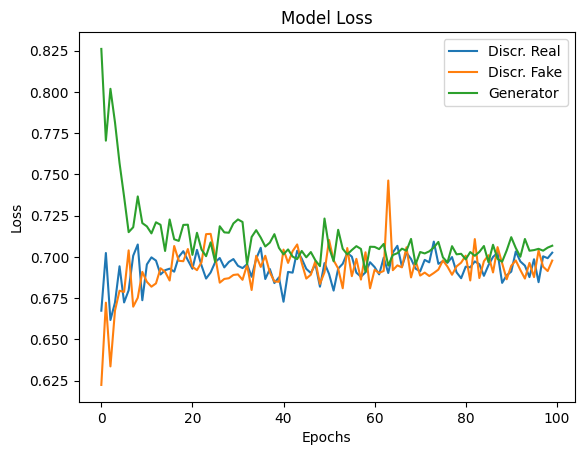

In [39]:
#10
train(generator, discriminator, gan_model, dataset, latent_dim, n_epochs=10)

In [40]:
generator.save('/content/drive/MyDrive/Colab Notebooks/DCGAN_fashion-mnist_generator.keras')

## Plotting the Final Losses

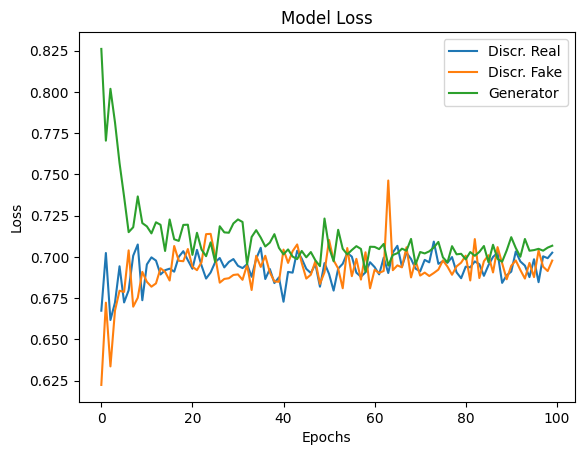

In [41]:
# plot the losses
plt.plot(d_loss_real_list, label='Discr. Real')
plt.plot(d_loss_fake_list, label='Discr. Fake')
plt.plot(g_loss_list, label='Generator')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Generating Images

In [42]:
# Now, let us load the generator model and generate images

# load model
model = load_model('/content/drive/MyDrive/Colab Notebooks/DCGAN_fashion-mnist_generator.keras') # Model trained for 100 epochs

# Plot generated images
def show_plot(examples, n):
	for i in range(n * n):
		plt.subplot(n, n, 1 + i)
		plt.axis('off')
		plt.imshow(examples[i, :, :, :])
	plt.show()

1/1 [==============================] - 0s 339ms/step


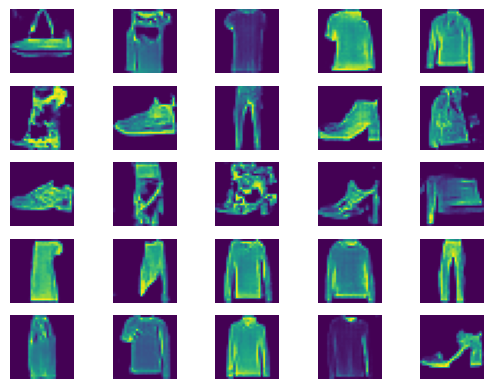

In [43]:
# generate images
latent_points = generate_latent_points(100, 25)  #Latent dim and n_samples
# generate images
X = model.predict(latent_points)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0

X = (X*255).astype(np.uint8)

# plot the result
show_plot(X, 5)